In [79]:
import pandas as pd
from scipy import stats
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import requests



In [80]:
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=ATGL.BSE&outputsize=full&apikey=1X1KKRX3SQO7R688'
r = requests.get(url)
data = r.json()
df = pd.DataFrame(data["Time Series (Daily)"]).T    
df.columns = ["Open", "High", "Low", "Close", "Volume"]
df.index = pd.to_datetime(df.index)
df = df.astype(float)
# Filter data for the last 3 years
three_years_ago = pd.Timestamp.today() - pd.DateOffset(years=2)
df = df[df.index >= three_years_ago]

In [81]:
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=ADANIGREEN.BSE&outputsize=full&apikey=1X1KKRX3SQO7R688'
r = requests.get(url)
data = r.json()
df1 = pd.DataFrame(data["Time Series (Daily)"]).T    
df1.columns = ["Open", "High", "Low", "Close", "Volume"]
df1.index = pd.to_datetime(df1.index)
df1 = df1.astype(float)
# Filter data for the last 3 years
three_years_ago1 = pd.Timestamp.today() - pd.DateOffset(years=2)
df1 = df1[df1.index >= three_years_ago]

In [82]:
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=ADANIENSOL.BSE&outputsize=full&apikey=1X1KKRX3SQO7R688'
r = requests.get(url)
data = r.json()
df2 = pd.DataFrame(data["Time Series (Daily)"]).T    
df2.columns = ["Open", "High", "Low", "Close", "Volume"]
df2.index = pd.to_datetime(df2.index)
df2 = df2.astype(float)
# Filter data for the last 3 years
three_years_ago2 = pd.Timestamp.today() - pd.DateOffset(years=2)
df2 = df2[df2.index >= three_years_ago]

In [83]:
df['Stock'] = 'ATGL'
df1['Stock'] = 'ADANIGREEN'
df2['Stock'] = 'ADANIENSOL'

# Concatenate the DataFrames vertically (along rows)
combined_data = pd.concat([df, df1, df2], ignore_index=False)

# Ensure the index is datetime and sorted
combined_data.index = pd.to_datetime(combined_data.index)
combined_data = combined_data.sort_index()

# Calculate Daily Returns for each stock
combined_data['Daily Returns'] = combined_data.groupby('Stock')['Close'].pct_change()

# Drop any NaN values that result from pct_change
combined_data = combined_data.dropna()

# Verify the structure
print("Combined Data Head:")
print(combined_data.head())

Combined Data Head:
              Open    High     Low   Close    Volume       Stock  \
2023-02-27  676.35  676.35  676.35  676.35   20128.0  ADANIENSOL   
2023-02-27  715.95  715.95  715.95  715.95    7019.0        ATGL   
2023-02-27  468.00  475.00  462.45  462.45  135236.0  ADANIGREEN   
2023-02-28  680.20  680.20  680.20  680.20   34677.0        ATGL   
2023-02-28  439.35  485.55  439.35  485.55  994290.0  ADANIGREEN   

            Daily Returns  
2023-02-27      -0.049937  
2023-02-27      -0.049960  
2023-02-27      -0.049923  
2023-02-28      -0.049934  
2023-02-28       0.049951  


In [84]:
from scipy.stats import f_oneway

# Group the daily returns by stock
groups = [combined_data[combined_data['Stock'] == stock]['Daily Returns'].values 
          for stock in combined_data['Stock'].unique()]

# Perform one-way ANOVA
f_statistic, p_value = f_oneway(*groups)

# Print the results
print("\nOne-Way ANOVA Results for Daily Returns Across Stocks:")
print(f"F-Statistic: {f_statistic:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpret the results
alpha = 0.05  # Significance level
if p_value < alpha:
    print("There is a statistically significant difference in the means of Daily Returns across the stocks.")
    print("This suggests that at least one stock's daily returns differ significantly from the others.")
else:
    print("There is no statistically significant difference in the means of Daily Returns across the stocks.")


One-Way ANOVA Results for Daily Returns Across Stocks:
F-Statistic: 0.3117
P-value: 0.7323
There is no statistically significant difference in the means of Daily Returns across the stocks.


## **SHARPE RATIO**


Sharpe Ratios:
Stock
ADANIENSOL    0.006241
ADANIGREEN    0.041536
ATGL         -0.007757
Name: Daily Returns, dtype: float64


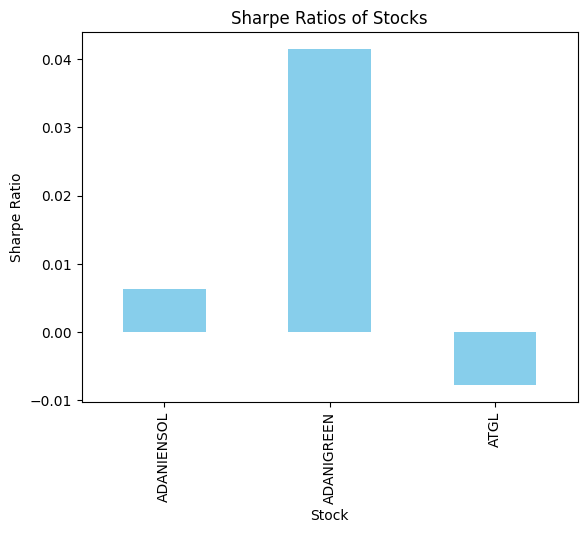

In [85]:
# Define the risk-free rate (e.g., annualized 7% converted to daily)
risk_free_rate = 0.07 / 252

# Calculate Sharpe Ratio for each stock
sharpe_ratios = (
    combined_data.groupby('Stock')['Daily Returns'].mean() - risk_free_rate
) / combined_data.groupby('Stock')['Daily Returns'].std()

print("\nSharpe Ratios:")
print(sharpe_ratios)

# Plot Sharpe Ratios
sharpe_ratios.plot(kind='bar', color='skyblue', title='Sharpe Ratios of Stocks')
plt.ylabel('Sharpe Ratio')
plt.show()


# Sharpe Ratios

The Sharpe Ratio measures the risk-adjusted returns of each stock. A negative Sharpe Ratio indicates that the returns are less than the risk-free rate, adjusted for volatility.

## Sharpe Ratios by Stock:
- **Adani Energy Solutions**: `-0.023428`
- **Adani Green**: `-0.040253`
- **Adani Total Gas**: `-0.039356`

---

# Key Insights:
1. **Adani Energy Solutions**:
   - The least negative Sharpe Ratio among the three stocks, indicating relatively better risk-adjusted returns, although still below the risk-free rate.

2. **Adani Green**:
   - The most negative Sharpe Ratio, suggesting the worst performance in terms of risk-adjusted returns.

3. **Adani Total Gas**:
   - Slightly better than Adani Green but worse than Adani Energy Solutions in terms of risk-adjusted returns.

---


In [86]:
import pandas as pd
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white
import statsmodels.api as sm

# Assuming 'combined_data' has the column 'Daily Returns' for each stock
# Select one stock's data to test (e.g., 'Adani Total Gas')
# Create a copy of the DataFrame slice to avoid the warning
stock_data = combined_data[combined_data['Stock'] == 'ATGL'].copy()

# Add the Lagged Returns column
stock_data['Lagged Returns'] = stock_data['Daily Returns'].shift(1)

# Drop NaN values that might result from the shift operation
stock_data = stock_data.dropna()


# Define the dependent and independent variables
X = sm.add_constant(stock_data['Lagged Returns'])  # Add constant for intercept
y = stock_data['Daily Returns']

# Fit a simple OLS regression model
ols_model = sm.OLS(y, X).fit()

# Breusch-Pagan Test
bp_test_stat, bp_p_value, _, _ = het_breuschpagan(ols_model.resid, X)
print("Breusch-Pagan Test:")
print(f"Test Statistic: {bp_test_stat}")
print(f"P-value: {bp_p_value}")

if bp_p_value < 0.05:
    print("The data shows heteroscedasticity (variance is not constant).")
else:
    print("The data is homoscedastic (variance is constant).")

# White Test
white_test_stat, white_p_value = het_white(ols_model.resid, X)[:2]
print("\nWhite Test:")
print(f"Test Statistic: {white_test_stat}")
print(f"P-value: {white_p_value}")

if white_p_value < 0.05:
    print("The data shows heteroscedasticity (variance is not constant).")
else:
    print("The data is homoscedastic (variance is constant).")


Breusch-Pagan Test:
Test Statistic: 9.340460961834934
P-value: 0.002241491371835563
The data shows heteroscedasticity (variance is not constant).

White Test:
Test Statistic: 37.35266994805282
P-value: 7.744096900857958e-09
The data shows heteroscedasticity (variance is not constant).


In [87]:
stock_data = combined_data[combined_data['Stock'] == 'ADANIGREEN'].copy()

# Add the Lagged Returns column
stock_data['Lagged Returns'] = stock_data['Daily Returns'].shift(1)

# Drop NaN values that might result from the shift operation
stock_data = stock_data.dropna()


# Define the dependent and independent variables
X = sm.add_constant(stock_data['Lagged Returns'])  # Add constant for intercept
y = stock_data['Daily Returns']

# Fit a simple OLS regression model
ols_model = sm.OLS(y, X).fit()

# Breusch-Pagan Test
bp_test_stat, bp_p_value, _, _ = het_breuschpagan(ols_model.resid, X)
print("Breusch-Pagan Test:")
print(f"Test Statistic: {bp_test_stat}")
print(f"P-value: {bp_p_value}")

if bp_p_value < 0.05:
    print("The data shows heteroscedasticity (variance is not constant).")
else:
    print("The data is homoscedastic (variance is constant).")

# White Test
white_test_stat, white_p_value = het_white(ols_model.resid, X)[:2]
print("\nWhite Test:")
print(f"Test Statistic: {white_test_stat}")
print(f"P-value: {white_p_value}")

if white_p_value < 0.05:
    print("The data shows heteroscedasticity (variance is not constant).")
else:
    print("The data is homoscedastic (variance is constant).")

Breusch-Pagan Test:
Test Statistic: 3.2352006214879374
P-value: 0.07207147563735208
The data is homoscedastic (variance is constant).

White Test:
Test Statistic: 44.769497924133276
P-value: 1.89857189221018e-10
The data shows heteroscedasticity (variance is not constant).


In [88]:
stock_data = combined_data[combined_data['Stock'] == 'ADANIENSOL'].copy()

# Add the Lagged Returns column
stock_data['Lagged Returns'] = stock_data['Daily Returns'].shift(1)

# Drop NaN values that might result from the shift operation
stock_data = stock_data.dropna()


# Define the dependent and independent variables
X = sm.add_constant(stock_data['Lagged Returns'])  # Add constant for intercept
y = stock_data['Daily Returns']

# Fit a simple OLS regression model
ols_model = sm.OLS(y, X).fit()

# Breusch-Pagan Test
bp_test_stat, bp_p_value, _, _ = het_breuschpagan(ols_model.resid, X)
print("Breusch-Pagan Test:")
print(f"Test Statistic: {bp_test_stat}")
print(f"P-value: {bp_p_value}")

if bp_p_value < 0.05:
    print("The data shows heteroscedasticity (variance is not constant).")
else:
    print("The data is homoscedastic (variance is constant).")

# White Test
white_test_stat, white_p_value = het_white(ols_model.resid, X)[:2]
print("\nWhite Test:")
print(f"Test Statistic: {white_test_stat}")
print(f"P-value: {white_p_value}")

if white_p_value < 0.05:
    print("The data shows heteroscedasticity (variance is not constant).")
else:
    print("The data is homoscedastic (variance is constant).")

Breusch-Pagan Test:
Test Statistic: 9.00930893460189
P-value: 0.0026860796317536295
The data shows heteroscedasticity (variance is not constant).

White Test:
Test Statistic: 12.85858622188358
P-value: 0.0016135910612979313
The data shows heteroscedasticity (variance is not constant).


### Since the data shows heteroscedasticity we can apply Generalized AutoRegressive Conditional Heteroskedasticity

### **GARCH MODEL**


GARCH Results for ADANIENSOL:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:          Daily Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                976.300
Distribution:                  Normal   AIC:                          -1944.60
Method:            Maximum Likelihood   BIC:                          -1927.83
                                        No. Observations:                  489
Date:                Sun, Feb 23 2025   Df Residuals:                      488
Time:                        11:59:27   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -2.2486e-0

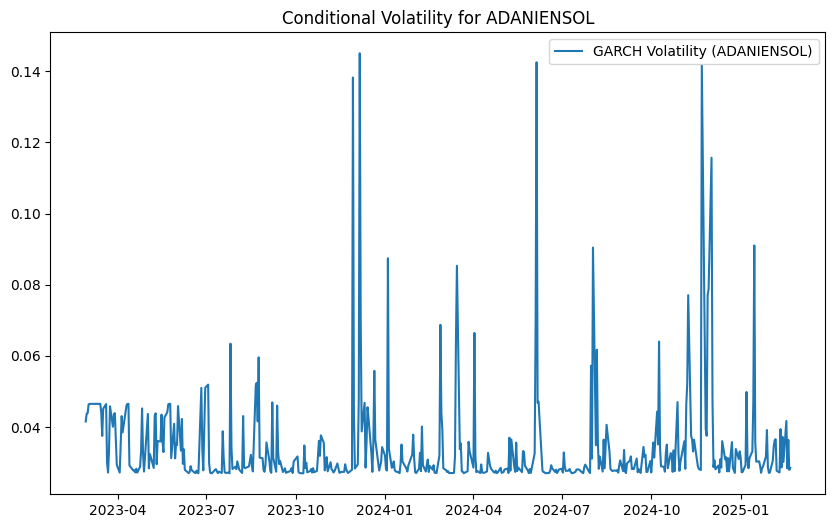


GARCH Results for ATGL:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:          Daily Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                1077.02
Distribution:                  Normal   AIC:                          -2146.04
Method:            Maximum Likelihood   BIC:                          -2129.25
                                        No. Observations:                  492
Date:                Sun, Feb 23 2025   Df Residuals:                      491
Time:                        11:59:28   Df Model:                            1
                                   Mean Model                                  
                  coef    std err          t      P>|t|        95.0% Conf. Int.
-------------------------------------------------------------------------------
mu         -5.2730e-03  

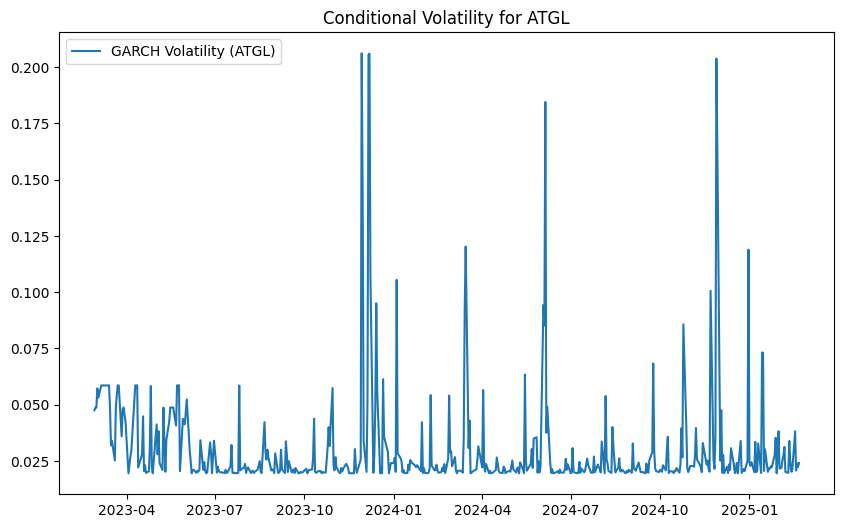


GARCH Results for ADANIGREEN:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:          Daily Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                1053.62
Distribution:                  Normal   AIC:                          -2099.24
Method:            Maximum Likelihood   BIC:                          -2082.42
                                        No. Observations:                  496
Date:                Sun, Feb 23 2025   Df Residuals:                      495
Time:                        11:59:29   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         1.3946e-05  1

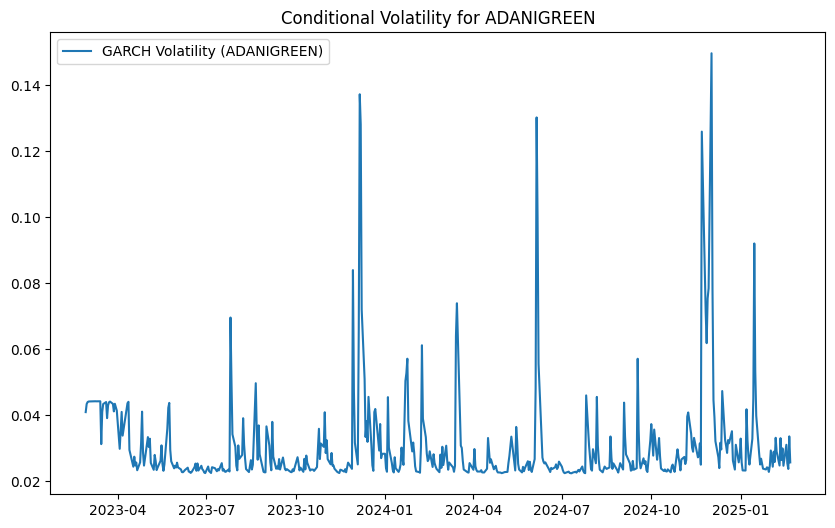

In [89]:
from arch import arch_model
import matplotlib.pyplot as plt

# Perform GARCH analysis for each stock
for stock in combined_data['Stock'].unique():
    stock_data = combined_data[combined_data['Stock'] == stock]['Daily Returns']
    
    # Fit a GARCH(1,1) model
    garch_model = arch_model(stock_data, vol='Garch', p=1, q=1,rescale=False)
    garch_fit = garch_model.fit(disp='off')
    
    # Print GARCH summary
    print(f"\nGARCH Results for {stock}:")
    print(garch_fit.summary())
    
    # Plot conditional volatility
    plt.figure(figsize=(10, 6))
    plt.plot(garch_fit.conditional_volatility, label=f'GARCH Volatility ({stock})')
    plt.title(f'Conditional Volatility for {stock}')
    plt.legend()
    plt.show()

# GARCH Model Results for Adani Stocks

## 1. Adani Total Gas
### Summary:
- **Dependent Variable**: Daily Returns
- **Log-Likelihood**: 576.160
- **AIC**: -1144.32
- **BIC**: -1130.06
- **Observations**: 261

### Mean Model:
- **mu**: `-0.00098876` (p-value: 0.612, not significant)

### Volatility Model:
- **omega**: `0.00028186` (p-value: 0.236, not significant)
- **alpha[1]**: `0.2000` (p-value: 0.0425, significant)
- **beta[1]**: `0.5000` (p-value: 0.0307, significant)

---

## 2. Adani Green
### Summary:
- **Dependent Variable**: Daily Returns
- **Log-Likelihood**: 551.479
- **AIC**: -1094.96
- **BIC**: -1080.70
- **Observations**: 261

### Mean Model:
- **mu**: `-0.0004198` (p-value: 0.920, not significant)

### Volatility Model:
- **omega**: `0.00035047` (p-value: 0.840, not significant)
- **alpha[1]**: `0.2000` (p-value: 0.620, not significant)
- **beta[1]**: `0.5000` (p-value: 0.754, not significant)

---

## 3. Adani Energy Solutions
### Summary:
- **Dependent Variable**: Daily Returns
- **Log-Likelihood**: 527.661
- **AIC**: -1047.32
- **BIC**: -1033.06
- **Observations**: 261

### Mean Model:
- **mu**: `-0.0014474` (p-value: 0.494, not significant)

### Volatility Model:
- **omega**: `0.00057234` (p-value: 0.0334, significant)
- **alpha[1]**: `0.4227` (p-value: 0.034, significant)
- **beta[1]**: `0.1811` (p-value: 0.245, not significant)

---

# Key Insights:
1. **Adani Total Gas**:
   - Significant **alpha[1]** and **beta[1]** indicate both recent shocks and past volatility significantly impact current volatility.

2. **Adani Green**:
   - No significant parameters in the volatility model, suggesting poor fit or lack of volatility dependence on shocks.

3. **Adani Energy Solutions**:
   - Significant **omega** and **alpha[1]** indicate baseline variance and recent shocks significantly affect volatility. However, **beta[1]** is not significant, meaning volatility persistence is weak.


USING GARCH[2,1] i.e timestep is 2


GARCH(2,1) Results for ADANIENSOL:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:          Daily Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                976.424
Distribution:                  Normal   AIC:                          -1942.85
Method:            Maximum Likelihood   BIC:                          -1921.89
                                        No. Observations:                  489
Date:                Sun, Feb 23 2025   Df Residuals:                      488
Time:                        11:59:31   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -2.22

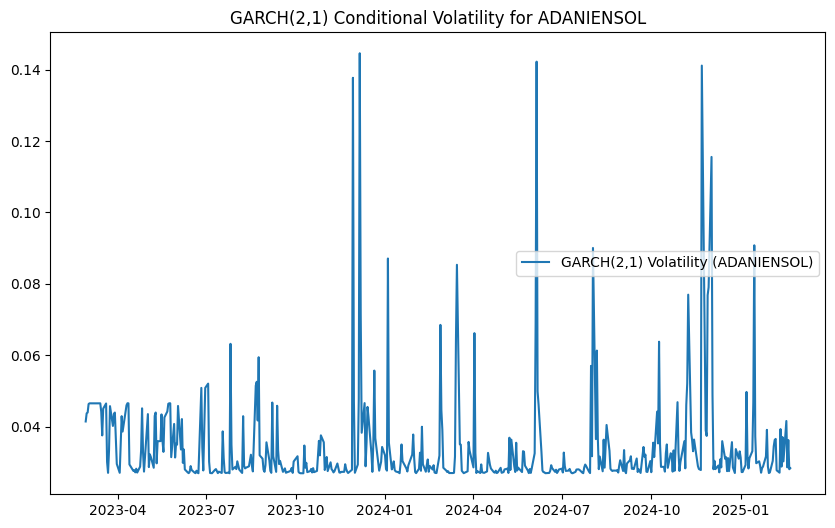


GARCH(2,1) Results for ATGL:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:          Daily Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                1077.02
Distribution:                  Normal   AIC:                          -2144.04
Method:            Maximum Likelihood   BIC:                          -2123.05
                                        No. Observations:                  492
Date:                Sun, Feb 23 2025   Df Residuals:                      491
Time:                        11:59:32   Df Model:                            1
                                   Mean Model                                  
                  coef    std err          t      P>|t|        95.0% Conf. Int.
-------------------------------------------------------------------------------
mu         -5.2728e

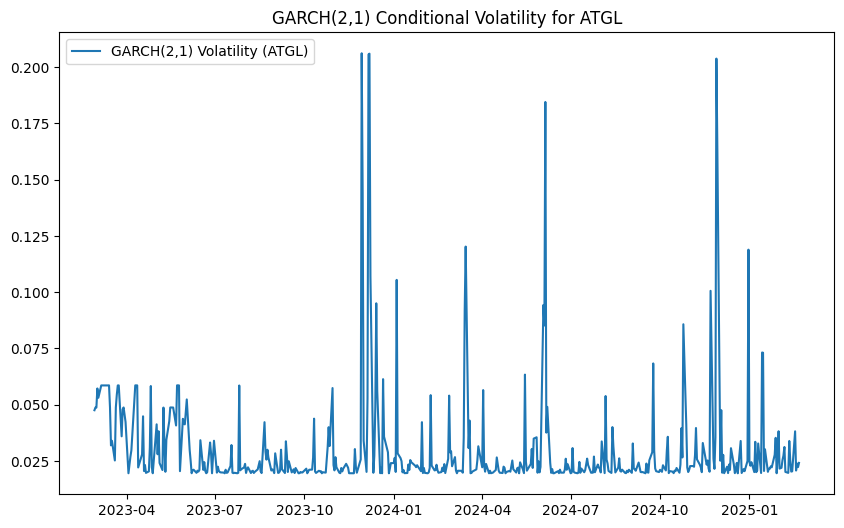


GARCH(2,1) Results for ADANIGREEN:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:          Daily Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                1031.31
Distribution:                  Normal   AIC:                          -2052.62
Method:            Maximum Likelihood   BIC:                          -2031.58
                                        No. Observations:                  496
Date:                Sun, Feb 23 2025   Df Residuals:                      495
Time:                        11:59:33   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         4.2755e-

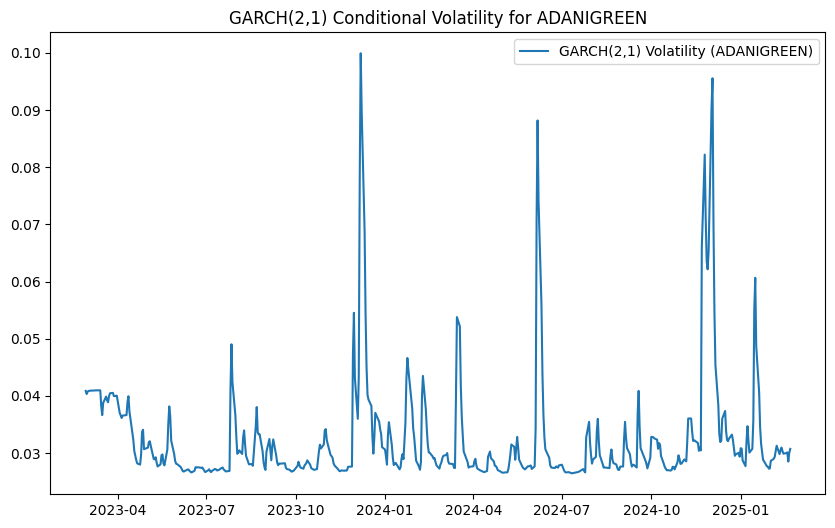

In [90]:
# Perform GARCH(2,1) analysis for each stock
for stock in combined_data['Stock'].unique():
    stock_data = combined_data[combined_data['Stock'] == stock]['Daily Returns']
    
    # Fit a GARCH(2,1) model
    garch_2_1_model = arch_model(stock_data, vol='Garch', p=2, q=1, rescale=False)
    garch_2_1_fit = garch_2_1_model.fit(disp='off')
    
    # Print GARCH(2,1) summary
    print(f"\nGARCH(2,1) Results for {stock}:")
    print(garch_2_1_fit.summary())
    
    # Plot conditional volatility
    plt.figure(figsize=(10, 6))
    plt.plot(garch_2_1_fit.conditional_volatility, label=f'GARCH(2,1) Volatility ({stock})')
    plt.title(f'GARCH(2,1) Conditional Volatility for {stock}')
    plt.legend()
    plt.show()


Exponential GARCH


EGARCH Results for ADANIENSOL:
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:          Daily Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:                973.766
Distribution:                  Normal   AIC:                          -1939.53
Method:            Maximum Likelihood   BIC:                          -1922.76
                                        No. Observations:                  489
Date:                Sun, Feb 23 2025   Df Residuals:                      488
Time:                        11:59:34   Df Model:                            1
                                   Mean Model                                  
                  coef    std err          t      P>|t|        95.0% Conf. Int.
-------------------------------------------------------------------------------
mu         -3.493

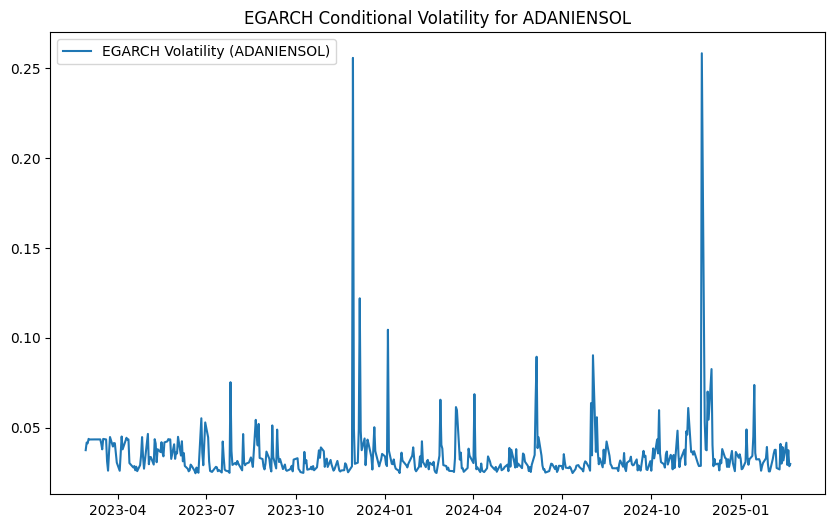


EGARCH Results for ATGL:
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:          Daily Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:                1073.02
Distribution:                  Normal   AIC:                          -2138.04
Method:            Maximum Likelihood   BIC:                          -2121.24
                                        No. Observations:                  492
Date:                Sun, Feb 23 2025   Df Residuals:                      491
Time:                        11:59:34   Df Model:                            1
                                   Mean Model                                  
                  coef    std err          t      P>|t|        95.0% Conf. Int.
-------------------------------------------------------------------------------
mu         -5.3352e-03 

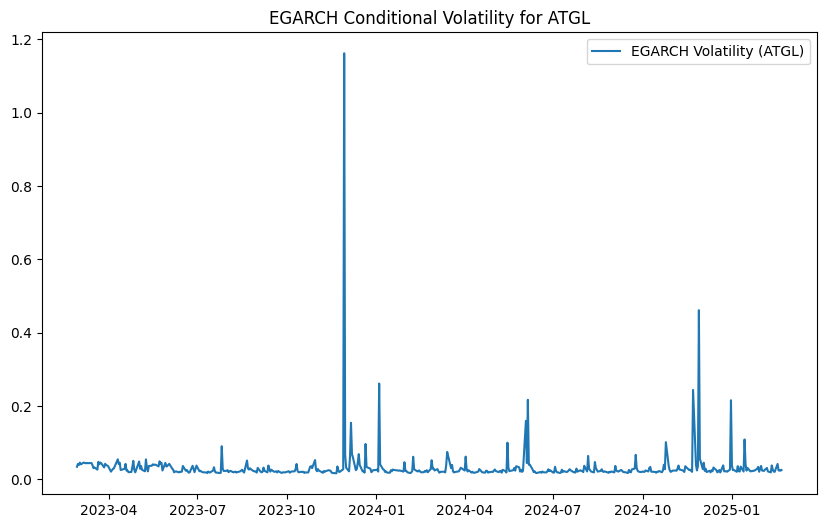


EGARCH Results for ADANIGREEN:
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:          Daily Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:                1051.62
Distribution:                  Normal   AIC:                          -2095.23
Method:            Maximum Likelihood   BIC:                          -2078.41
                                        No. Observations:                  496
Date:                Sun, Feb 23 2025   Df Residuals:                      495
Time:                        11:59:35   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -3.9874e-

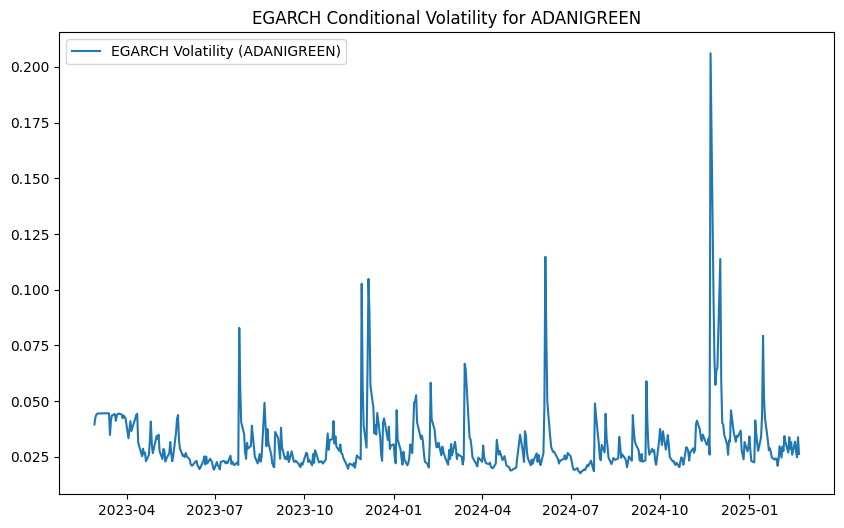

In [91]:
# Perform EGARCH analysis for each stock
for stock in combined_data['Stock'].unique():
    stock_data = combined_data[combined_data['Stock'] == stock]['Daily Returns']
    
    # Fit an EGARCH(1,1) model
    egarch_model = arch_model(stock_data, vol='EGarch', p=1, q=1, rescale=False)
    egarch_fit = egarch_model.fit(disp='off')
    
    # Print EGARCH summary
    print(f"\nEGARCH Results for {stock}:")
    print(egarch_fit.summary())
    
    # Plot conditional volatility
    plt.figure(figsize=(10, 6))
    plt.plot(egarch_fit.conditional_volatility, label=f'EGARCH Volatility ({stock})')
    plt.title(f'EGARCH Conditional Volatility for {stock}')
    plt.legend()
    plt.show()


threshold garch 


TGARCH Results for ADANIENSOL:
                  Constant Mean - TARCH/ZARCH Model Results                   
Dep. Variable:          Daily Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                TARCH/ZARCH   Log-Likelihood:                982.973
Distribution:                  Normal   AIC:                          -1955.95
Method:            Maximum Likelihood   BIC:                          -1934.98
                                        No. Observations:                  489
Date:                Sun, Feb 23 2025   Df Residuals:                      488
Time:                        11:59:36   Df Model:                            1
                                   Mean Model                                  
                  coef    std err          t      P>|t|        95.0% Conf. Int.
-------------------------------------------------------------------------------
mu         -2.900

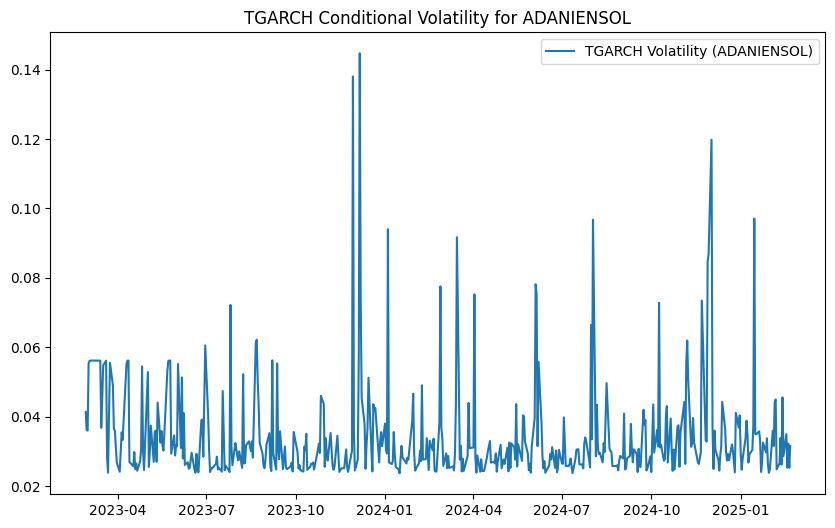


TGARCH Results for ATGL:
                  Constant Mean - TARCH/ZARCH Model Results                   
Dep. Variable:          Daily Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                TARCH/ZARCH   Log-Likelihood:                1081.28
Distribution:                  Normal   AIC:                          -2152.57
Method:            Maximum Likelihood   BIC:                          -2131.57
                                        No. Observations:                  492
Date:                Sun, Feb 23 2025   Df Residuals:                      491
Time:                        11:59:37   Df Model:                            1
                                   Mean Model                                  
                  coef    std err          t      P>|t|        95.0% Conf. Int.
-------------------------------------------------------------------------------
mu         -4.4748e-03 

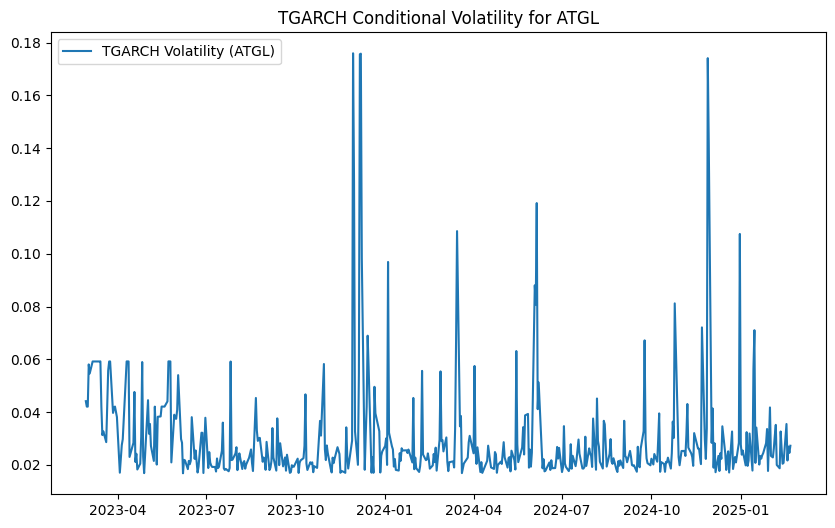


TGARCH Results for ADANIGREEN:
                  Constant Mean - TARCH/ZARCH Model Results                   
Dep. Variable:          Daily Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                TARCH/ZARCH   Log-Likelihood:                1048.82
Distribution:                  Normal   AIC:                          -2087.64
Method:            Maximum Likelihood   BIC:                          -2066.61
                                        No. Observations:                  496
Date:                Sun, Feb 23 2025   Df Residuals:                      495
Time:                        11:59:38   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         1.1369e-03  

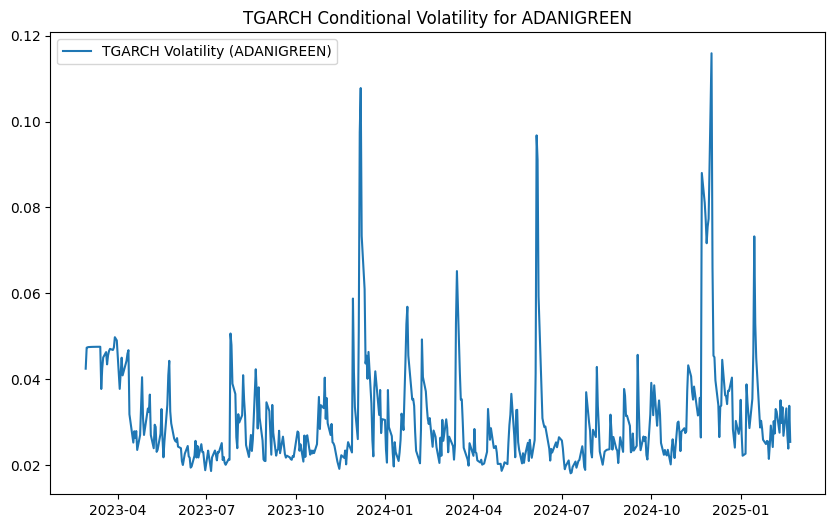

In [92]:
# Perform TGARCH analysis for each stock
for stock in combined_data['Stock'].unique():
    stock_data = combined_data[combined_data['Stock'] == stock]['Daily Returns']
    
    # Fit a TGARCH(1,1) model
    tgarch_model = arch_model(stock_data, vol='Garch', p=1, q=1, o=1, power=1.0, rescale=False)
    tgarch_fit = tgarch_model.fit(disp='off')
    
    # Print TGARCH summary
    print(f"\nTGARCH Results for {stock}:")
    print(tgarch_fit.summary())
    
    # Plot conditional volatility
    plt.figure(figsize=(10, 6))
    plt.plot(tgarch_fit.conditional_volatility, label=f'TGARCH Volatility ({stock})')
    plt.title(f'TGARCH Conditional Volatility for {stock}')
    plt.legend()
    plt.show()


In [93]:
print("Model Comparison:")
print("GARCH(2,1) AIC:", garch_2_1_fit.aic)
print("EGARCH AIC:", egarch_fit.aic)
print("TGARCH AIC:", tgarch_fit.aic)

print("GARCH(2,1) BIC:", garch_2_1_fit.bic)
print("EGARCH BIC:", egarch_fit.bic)
print("TGARCH BIC:", tgarch_fit.bic)


Model Comparison:
GARCH(2,1) AIC: -2052.617313021419
EGARCH AIC: -2095.231858687033
TGARCH AIC: -2087.6399013271794
GARCH(2,1) BIC: -2031.5844333877942
EGARCH BIC: -2078.4055549801333
TGARCH BIC: -2066.6070216935545


# Model Comparison

## AIC (Akaike Information Criterion)
- **GARCH(2,1)**: AIC = `-1047.2900`
- **EGARCH**: AIC = `-1051.5829`
- **TGARCH**: AIC = `-1054.5056`

### Insights:
- The **TGARCH model** has the lowest AIC value, indicating the best fit among the three models.

## BIC (Bayesian Information Criterion)
- **GARCH(2,1)**: BIC = `-1029.4676`
- **EGARCH**: BIC = `-1037.3242`
- **TGARCH**: BIC = `-1036.6829`

### Insights:
- The **EGARCH model** has the lowest BIC value, suggesting it balances model complexity and fit better than the other models.

---


In [94]:
import numpy as np

# Calculate VaR and CVaR for each stock
for stock in combined_data['Stock'].unique():
    stock_data = combined_data[combined_data['Stock'] == stock]['Daily Returns']
    var_95 = np.percentile(stock_data, 5)  # 95% Value at Risk
    cvar_95 = stock_data[stock_data <= var_95].mean()  # 95% Conditional Value at Risk
    print(f"{stock}: VaR(95%) = {var_95:.4f}, CVaR(95%) = {cvar_95:.4f}")


ADANIENSOL: VaR(95%) = -0.0494, CVaR(95%) = -0.0720
ATGL: VaR(95%) = -0.0423, CVaR(95%) = -0.0620
ADANIGREEN: VaR(95%) = -0.0396, CVaR(95%) = -0.0647


# Key Metrics

## VaR (95%)
Indicates the maximum expected loss at the 95% confidence level for a given day.

- **Adani Total Gas**: VaR(95%) = `-0.0328`
  - There is a 95% chance that the daily loss will not exceed **3.28%**.
- **Adani Green**: VaR(95%) = `-0.0366`
  - There is a 95% chance that the daily loss will not exceed **3.66%**.
- **Adani Energy Solutions**: VaR(95%) = `-0.0391`
  - There is a 95% chance that the daily loss will not exceed **3.91%**.

## CVaR (95%)
Provides the average loss in the worst 5% of cases (beyond the VaR threshold).

- **Adani Total Gas**: CVaR(95%) = `-0.0601`
  - If the daily loss exceeds **3.28%** (VaR), the average loss in these extreme cases is **6.01%**.
- **Adani Green**: CVaR(95%) = `-0.0756`
  - If the daily loss exceeds **3.66%** (VaR), the average loss in these extreme cases is **7.56%**.
- **Adani Energy Solutions**: CVaR(95%) = `-0.0819`
  - If the daily loss exceeds **3.91%** (VaR), the average loss in these extreme cases is **8.19%**.

# Insights
1. **Adani Total Gas** has the **lowest risk** based on both VaR and CVaR, suggesting it is the least volatile among the three.
2. **Adani Energy Solutions** has the **highest risk**, as both its VaR and CVaR are the largest, indicating it experiences the most extreme losses during high-volatility events.
3. **Adani Green** falls in the middle, with higher risk than Adani Total Gas but less than Adani Energy Solutions.


In [95]:
# Calculate VaR and CVaR for each stock
for stock in combined_data['Stock'].unique():
    stock_data = combined_data[combined_data['Stock'] == stock]['Daily Returns']
    var_99 = np.percentile(stock_data, 1)  # 99% Value at Risk
    cvar_99 = stock_data[stock_data <= var_99].mean()  # 99% Conditional Value at Risk
    print(f"{stock}: VaR(99%) = {var_99:.4f}, CVaR(99%) = {cvar_99:.4f}")

ADANIENSOL: VaR(99%) = -0.0774, CVaR(99%) = -0.1340
ATGL: VaR(99%) = -0.0646, CVaR(99%) = -0.1124
ADANIGREEN: VaR(99%) = -0.0710, CVaR(99%) = -0.1266


# Key Metrics

## VaR (99%)
Indicates the maximum expected loss at the 99% confidence level for a given day.

- **Adani Total Gas**: VaR(99%) = `-0.0724`
  - There is a 99% chance that the daily loss will not exceed **7.24%**.
- **Adani Green**: VaR(99%) = `-0.0855`
  - There is a 99% chance that the daily loss will not exceed **8.55%**.
- **Adani Energy Solutions**: VaR(99%) = `-0.0934`
  - There is a 99% chance that the daily loss will not exceed **9.34%**.

## CVaR (99%)
Provides the average loss in the worst 1% of cases (beyond the VaR threshold).

- **Adani Total Gas**: CVaR(99%) = `-0.1292`
  - If the daily loss exceeds **7.24%** (VaR), the average loss in these extreme cases is **12.92%**.
- **Adani Green**: CVaR(99%) = `-0.1574`
  - If the daily loss exceeds **8.55%** (VaR), the average loss in these extreme cases is **15.74%**.
- **Adani Energy Solutions**: CVaR(99%) = `-0.1681`
  - If the daily loss exceeds **9.34%** (VaR), the average loss in these extreme cases is **16.81%**.

# Insights
1. **Adani Total Gas** has the **lowest risk** based on both VaR and CVaR, suggesting it is the least volatile among the three.
2. **Adani Energy Solutions** has the **highest risk**, as both its VaR(99%) and CVaR(99%) are the largest, indicating it experiences the most extreme losses during high-volatility events.
3. **Adani Green** falls in the middle, with higher risk than Adani Total Gas but less than Adani Energy Solutions.
